In [1]:
import numpy as np 
import argparse

filename   = str("bin_files/002_00000001.bin")
pointcloud = np.fromfile(filename, dtype=np.float32)
pointcloud = pointcloud.reshape([-1,4])

print('LiDAR data loaded as a variable pointcloud')

str1= str('\nLidar data file : ') + str(filename) + str('\nSize of pointcloud data = ') + str(pointcloud.shape)
print(str1)

LiDAR data loaded as a variable pointcloud

Lidar data file : bin_files/002_00000001.bin
Size of pointcloud data = (92246, 4)


In [11]:
def cart2Spherical_np(xyz):
    ptsnew = np.zeros((xyz.shape[0],4))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,1] = np.sqrt(xy + xyz[:,2]**2)         # theta for elevation angle defined from Z-axis down
    ptsnew[:,2] = np.arctan2(np.sqrt(xy), xyz[:,2]) # phi
    ptsnew[:,0] = np.arctan2(xyz[:,1], xyz[:,0])    # r
    ptsnew[:,3] = xyz[:,3]
    return ptsnew

In [12]:
polar_pointcloud = cart2Spherical_np(pointcloud)

### Visualize in polar co-ordinate space

In [25]:
def visualize_3d(pointcloud,cloud_color,Point_size):
    import pptk
    import numpy as np 
    
    # Extract first three points as x y z inputs and 4th for reflectivity value
    P = pointcloud[:,0:3]
    
    a = pointcloud.shape[0]
    R = np.ones((a))*20
    
    if pointcloud.shape[1]==4:
        R   = pointcloud[:,3]
    
    # define color channels
    rgb = np.ones((P.shape))*cloud_color # for grayish effect [200,200,200]
    
    if len(cloud_color)<3:
        rgb = cloud_color
    
    # Visualize point cloud
    v = pptk.viewer(P)
    v.set(lookat = [0,0,0])             # set zero /ego vehicle coordinate
    v.attributes(rgb/255, R)
    v.set(floor_color = [0,0,0,0])
    v.set(show_grid=0)             
    v.set(point_size=Point_size)        # for better visualization point_size = 0.001

In [62]:
#scale for better visualization
polar_pointcloud_scaled = polar_pointcloud*[19,1,23,1]

visualize_3d(polar_pointcloud_scaled,[190,190,190],0.001)

### Visulaize pointcloud with RGB color proportional to r, theta and phi 

In [107]:
r_max     = np.max(polar_pointcloud[:,2])*3/3
theta_max = np.max(polar_pointcloud[:,0])*3/3
phi_max   = np.max(polar_pointcloud[:,1])/3

print('max of r, theta, phi = ',str(r_max),' ',str(theta_max),' ',str(phi_max))

rgb_from_polar_pointcloud = polar_pointcloud[:,0:3]*[1/theta_max,1/phi_max,1/r_max]

import pptk
v = pptk.viewer(pointcloud[:,0:3],rgb_from_polar_pointcloud)
v.set(floor_color = [0,0,0,0.5])
v.set(show_grid=0)
v.set(lookat = [0,0,0])

('max of r, theta, phi = ', '1.9541178941726685', ' ', '3.1415767669677734', ' ', '23.324966430664062')


### Generate the projected 2D depth image w.r.t horizontal and vertical angels, with intensity value using the distance. Visualize the 2D depth image

In [108]:
def point_cloud_top_view_distance_intensity(velo,fwd_range,side_range,height_range,name = 'fig_name'):
    
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    from PIL import Image
    import numpy as np 
    
    x_points = velo[:, 0]
    y_points = velo[:, 1]
    z_points = velo[:, 2]
    r        = velo[:, 3]
    
    f_filt   = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt   = np.logical_and((y_points > -side_range[1]), (y_points < -side_range[0]))
    filter   = np.logical_and(f_filt, s_filt)
    indices  = np.argwhere(filter).flatten()
    
    # KEEPERS
    x_points = x_points[indices]
    y_points = y_points[indices]
    z_points = z_points[indices]
    r_points = r[indices]
    
    res      = 0.05
    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img    = (-y_points / res).astype(np.int32)  # x axis is -y in LIDAR
    y_img    = (-x_points / res).astype(np.int32)  # y axis is -x in LIDAR
    
    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor and ceil used to prevent anything being rounded to below 0 after shift
    x_img   -= int(np.floor(side_range[0] / res))
    y_img   += int(np.ceil(fwd_range[1] / res))

    # CLIP HEIGHT VALUES - to between min and max heights
    pixel_values = np.clip(a     = z_points,
                           a_min = height_range[0],
                           a_max = height_range[1])
    
    def scale_to_255(a, min, max, dtype = np.uint8):
        return (((a - min) / float(max - min)) * 255).astype(dtype)

    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    pixel_values  = scale_to_255(pixel_values, min = height_range[0], max = height_range[1])
    
    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = 1+int((side_range[1] - side_range[0])/res)
    y_max = 1+int((fwd_range[1] - fwd_range[0])/res)
    im    = np.zeros([y_max, x_max], dtype=np.uint8)

    # pixel value based on distance
    D_points = np.sqrt(x_points*x_points + y_points*y_points + z_points*z_points)
    D_points = D_points*255/D_points.max() 
    
    # FILL PIXEL VALUES IN IMAGE ARRAY
    im[y_img, x_img]   =D_points*2 # pixel_values
        
    plt.figure(figsize = (10,10))
    a = plt.imshow(im,vmin = 0, vmax=255)
    
    ax = plt.gca()
    rect = Rectangle((580,565),40,70,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #plt.text(600,575, "Ego Vehicle",horizontalalignment='center',rotation='vertical',color='red')
    
    return a

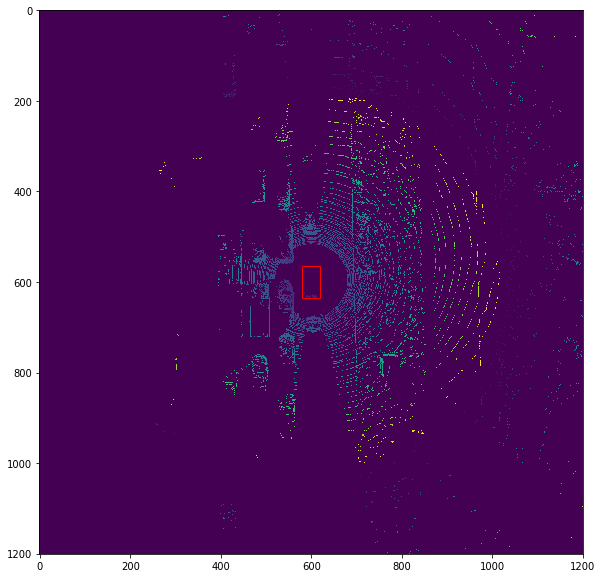

In [110]:
b = point_cloud_top_view_distance_intensity(pointcloud,(-30,30),(-30,30),(-3,10),name = 'fig_name')

### Front view 

In [121]:
def point_cloud_front_view_distance_intensity(velo,fwd_range,side_range,height_range,name = 'fig_name'):
    
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    from PIL import Image
    import numpy as np 
    
    x_points = velo[:, 0]
    y_points = velo[:, 1]
    z_points = velo[:, 2]
    r        = velo[:, 3]
    
    f_filt   = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt   = np.logical_and((y_points > -side_range[1]), (y_points < -side_range[0]))
    filter   = np.logical_and(f_filt, s_filt)
    indices  = np.argwhere(filter).flatten()
    
    # KEEPERS
    x_points = x_points[indices]
    y_points = y_points[indices]
    z_points = z_points[indices]
    r_points = r[indices]
    
    res      = 0.05
    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img    = (-y_points / res).astype(np.int32)  # x axis is -y in LIDAR
    y_img    = (-z_points / res).astype(np.int32)  # y axis is -x in LIDAR
    
    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor and ceil used to prevent anything being rounded to below 0 after shift
    x_img   -= int(np.floor(side_range[0] / res))
    y_img   += int(np.ceil(height_range[1] / res))

    
    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = 1+int((side_range[1] - side_range[0])/res)
    y_max = 1+int((height_range[1] - height_range[0])/res)
    im    = np.zeros([y_max, x_max], dtype=np.uint8)

    # pixel value based on distance
    D_points = np.sqrt(x_points*x_points + y_points*y_points + z_points*z_points)
    D_points = D_points*255/D_points.max() 
    
    # FILL PIXEL VALUES IN IMAGE ARRAY
    im[y_img, x_img]   =D_points*2 # pixel_values
        
    plt.figure(figsize = (50,50))
    a = plt.imshow(im,vmin = 0, vmax=255)
    
    ax = plt.gca()
    rect = Rectangle((580,565),40,70,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #plt.text(600,575, "Ego Vehicle",horizontalalignment='center',rotation='vertical',color='red')
    
    return a

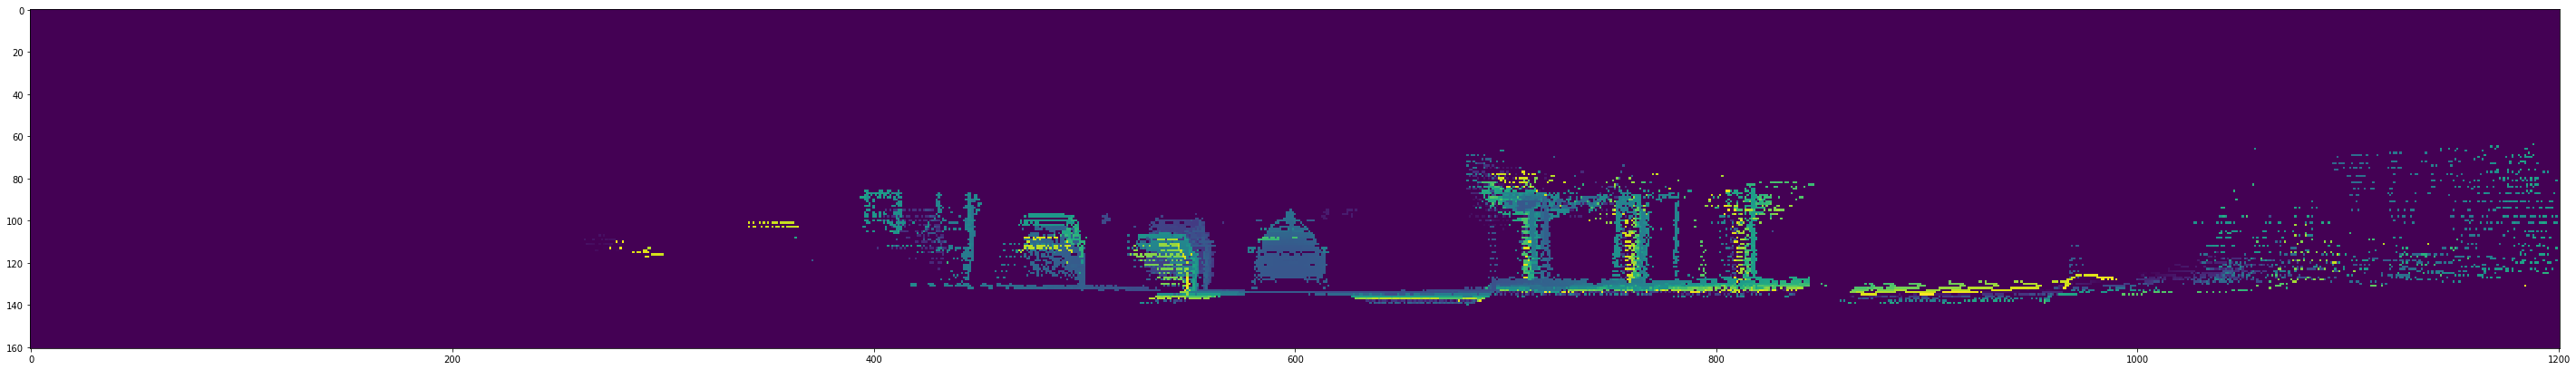

In [122]:
positive_x_pointcloud = pointcloud[pointcloud[:,0]>0]

c = point_cloud_front_view_distance_intensity(positive_x_pointcloud,(-30,30),(-30,30),(-3,5),name = 'fig_name')